In [ ]:
!pip uninstall numpy -y
!pip install numpy==1.23.5
!pip install docker
!pip install optuna

import numpy as np
import random
import docker
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

import torch
from torch import nn
from torch.distributions import Categorical
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader

from gym.envs import register
import gym
import gym.spaces as Space

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

#bool8 still in use in gym's librairy for some reason..
np.bool8 = np.bool_

In [2]:
data = pd.read_csv("response_times.csv")
df = pd.DataFrame(data)

df["CPU"] = df["CPU"].apply(lambda x: int(x/1000))
df["Memory"] = df["Memory"].apply(lambda x: int("".join(x[:-1]))/1000)
df["ResponseTimeCpus"] = df["ResponseTimeCpus"].apply(lambda x: int(x*1000))
df["ResponseTimeMems"] = df["ResponseTimeMems"].apply(lambda x: int(x*1000))

df.head(5)

,Timestamp,CPU,Memory,ResponseTimeCpus,ResponseTimeMems
0,2025-01-10 11:25:28,72,1.20,985,223
1,2025-01-10 11:25:45,83,0.95,831,243
2,2025-01-10 11:26:06,45,0.60,1773,807
3,2025-01-10 11:26:28,29,0.45,3203,1811
4,2025-01-10 11:26:47,66,1.00,1026,298


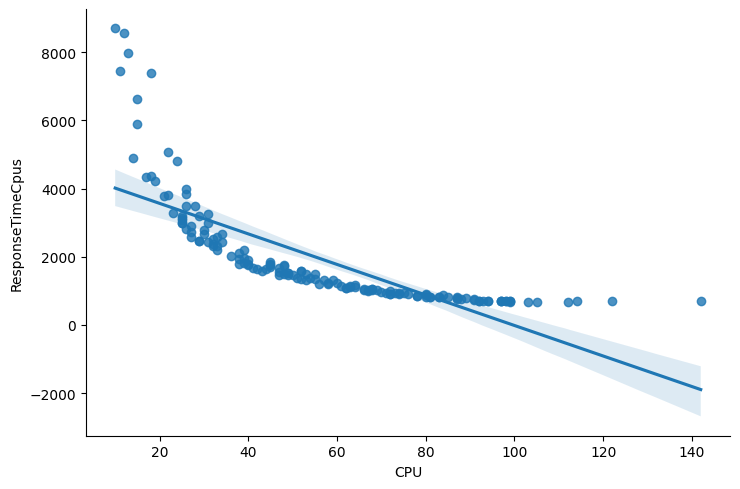

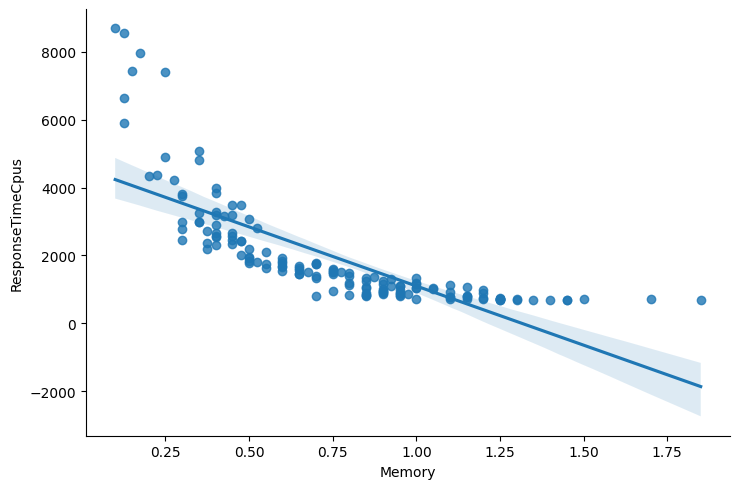

In [3]:
sns.lmplot(data=df, x="CPU", y="ResponseTimeCpus", aspect=1.5)
plt.show()

# Plot Memory vs ResponseTimeCpus
sns.lmplot(data=df, x="Memory", y="ResponseTimeCpus", aspect=1.5)
plt.show()

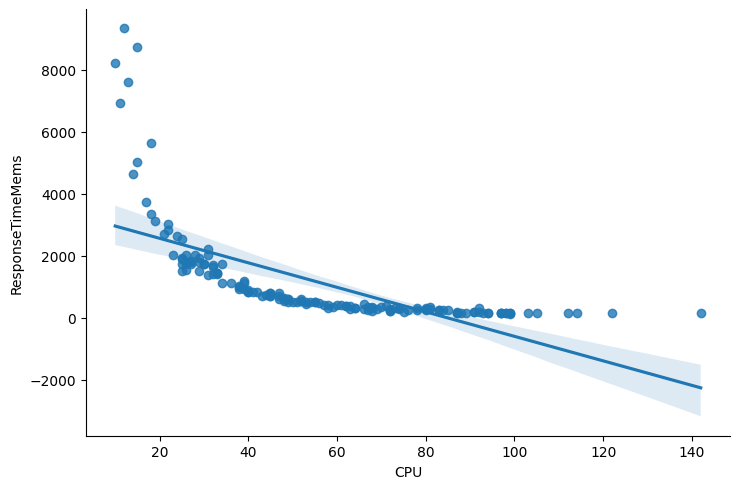

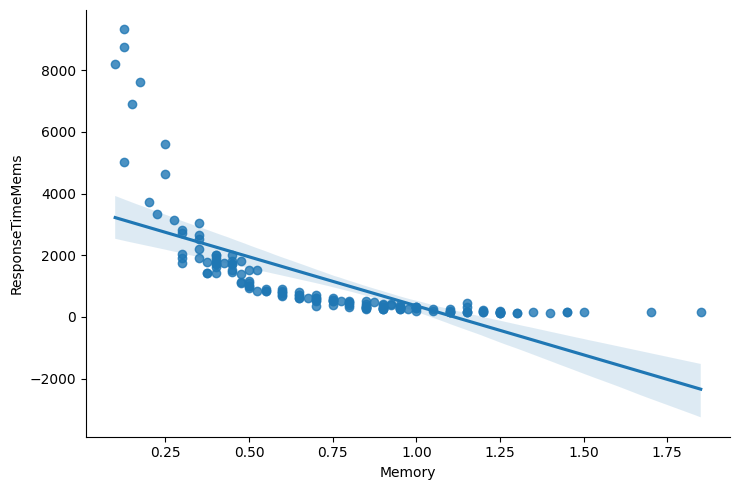

In [4]:
sns.lmplot(data=df, x="CPU", y="ResponseTimeMems", aspect=1.5)
plt.show()

# Plot Memory vs ResponseTimeCpus
sns.lmplot(data=df, x="Memory", y="ResponseTimeMems", aspect=1.5)
plt.show()

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters for ResponseTimeMems: {'svr__C': 100, 'svr__epsilon': 0.1, 'svr__gamma': 'scale'}
Tuned SVM Regression for ResponseTimeMems
MSE: 45555.94
R-squared: 0.91


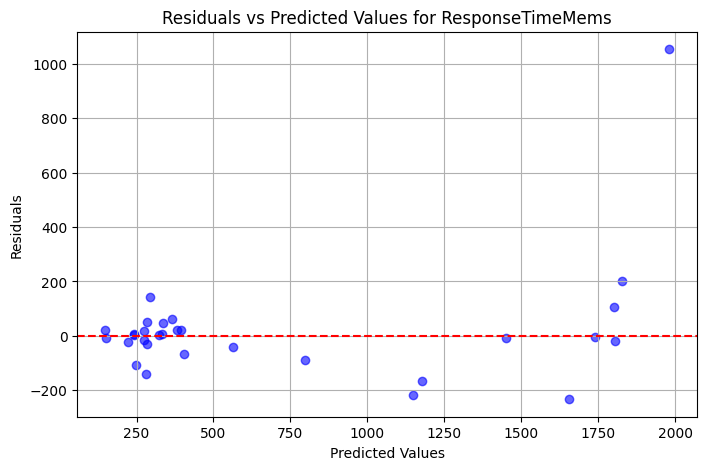

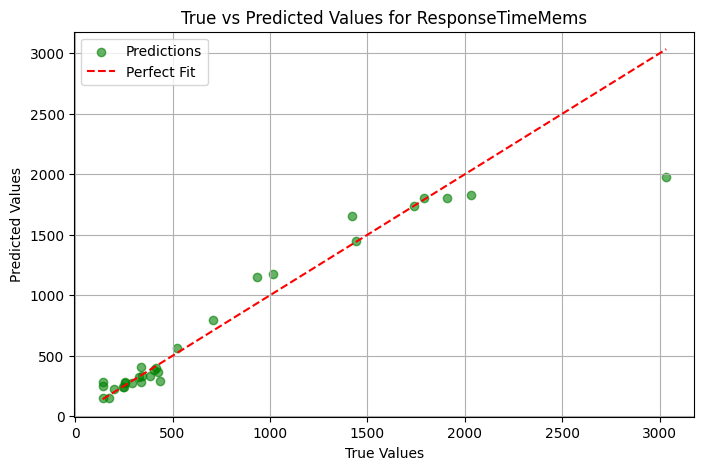

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters for ResponseTimeCpus: {'svr__C': 100, 'svr__epsilon': 0.1, 'svr__gamma': 'scale'}
Tuned SVM Regression for ResponseTimeCpus
MSE: 173205.98
R-squared: 0.83


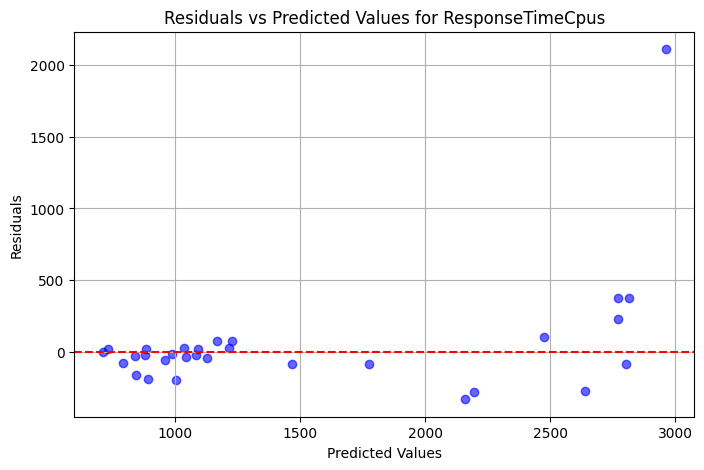

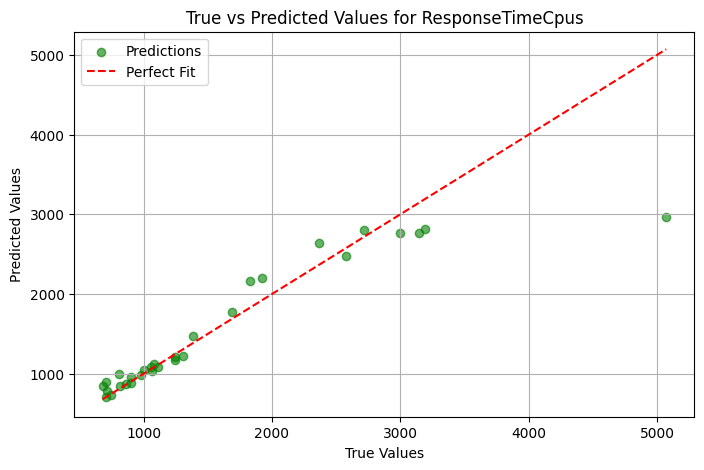

In [11]:
param_grid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 1],
    'svr__gamma': ['scale', 0.01, 0.1, 1]
}

X = df[["CPU", "Memory"]]

# Train for ResponseTimeMems
y_mems = df["ResponseTimeMems"]
X_train, X_test, y_train, y_test = train_test_split(X, y_mems, test_size=0.2, random_state=42)

svm_pipeline = make_pipeline(StandardScaler(), SVR(kernel='rbf'))

grid_search_mem = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='r2', verbose=1)
grid_search_mem.fit(X_train, y_train)

print("Best Parameters for ResponseTimeMems:", grid_search_mem.best_params_)
best_model_mem = grid_search_mem.best_estimator_
torch.save(best_model_mem, "best_model_mem")

svm_test_preds_mem = best_model_mem.predict(X_test)
svm_mse_mem = mean_squared_error(y_test, svm_test_preds_mem)
svm_r2_mem = r2_score(y_test, svm_test_preds_mem)
print(f"Tuned SVM Regression for ResponseTimeMems\nMSE: {svm_mse_mem:.2f}\nR-squared: {svm_r2_mem:.2f}")

# Residuals for ResponseTimeMems
residuals_mem = y_test - svm_test_preds_mem

# Residuals vs Predicted Values Plot for ResponseTimeMems
plt.figure(figsize=(8, 5))
plt.scatter(svm_test_preds_mem, residuals_mem, color="blue", alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values for ResponseTimeMems")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid()
plt.show()

# True vs Predicted Plot for ResponseTimeMems
plt.figure(figsize=(8, 5))
plt.scatter(y_test, svm_test_preds_mem, color="green", alpha=0.6, label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")
plt.title("True vs Predicted Values for ResponseTimeMems")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid()
plt.show()

# Now, train for ResponseTimeCpus
y_cpus = df["ResponseTimeCpus"]
X_train, X_test, y_train, y_test = train_test_split(X, y_cpus, test_size=0.2, random_state=42)

grid_search_cpu = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='r2', verbose=1)
grid_search_cpu.fit(X_train, y_train)

print("Best Parameters for ResponseTimeCpus:", grid_search_cpu.best_params_)
best_model_cpu = grid_search_cpu.best_estimator_
torch.save(best_model_cpu, "best_model_cpu")

svm_test_preds_cpu = best_model_cpu.predict(X_test)
svm_mse_cpu = mean_squared_error(y_test, svm_test_preds_cpu)
svm_r2_cpu = r2_score(y_test, svm_test_preds_cpu)
print(f"Tuned SVM Regression for ResponseTimeCpus\nMSE: {svm_mse_cpu:.2f}\nR-squared: {svm_r2_cpu:.2f}")

# Residuals for ResponseTimeCpus
residuals_cpu = y_test - svm_test_preds_cpu

# Residuals vs Predicted Values Plot for ResponseTimeCpus
plt.figure(figsize=(8, 5))
plt.scatter(svm_test_preds_cpu, residuals_cpu, color="blue", alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values for ResponseTimeCpus")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid()
plt.show()

# True vs Predicted Plot for ResponseTimeCpus
plt.figure(figsize=(8, 5))
plt.scatter(y_test, svm_test_preds_cpu, color="green", alpha=0.6, label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")
plt.title("True vs Predicted Values for ResponseTimeCpus")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid()
plt.show()

In [27]:
class BackboneNetwork(nn.Module):
    """
    Purpose:
        TThis class represents a neural network backbone designed for reinforcement learning agents, specifically for PPO 
        (Proximal Policy Optimization) and A2C (Advantage Actor-Critic) algorithms, designed to process input features
        and produce either policy predictions (for the actor) or value estimations (for the critic). The network includes
        multiple layers, dropout for regularization, and an activation function for non-linearity. It also includes several 
    
    Arguments:
        in_features (int): The number of input features to the network.
        hidden_dimensions (int): The number of neurons in the hidden layers.
        out_features (int): The number of output features (e.g., action probabilities for the actor, value estimate for the critic).
        dropout (float): Dropout probability for regularization.
        activation (callable, optional): Activation function applied after each layer. Default is ReLU.

    Notes:
        - Xavier Initialization: The network weights are initialized using Xavier uniform initialization to ensure stable gradients.
        - Gradient Clipping: Gradients are clipped during training to prevent explosion or vanishing gradients.
        - Scheduler: A learning rate scheduler adjusts the learning rate dynamically during training for better convergence.
        - Entropy Coefficient: This regularization encourages exploration by preventing the policy from becoming deterministic too early.
    
    Output:
        Tensor: The processed output tensor from the final layer of the network.
    """
    def __init__(self, in_features, hidden_dimensions, out_features, dropout, activation=F.relu):
        super().__init__()
        self.layer1 = nn.Linear(in_features, hidden_dimensions)
        self.layer2 = nn.Linear(hidden_dimensions, hidden_dimensions)
        self.layer3 = nn.Linear(hidden_dimensions, out_features)
        self.dropout = nn.Dropout(dropout)
        self.activation = activation
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x) 
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.activation(x) 
        x = self.dropout(x)
        x = self.layer3(x)
        return x

class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        self.actor = actor
        self.critic = critic
        
    def forward(self, state):
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        return action_pred, value_pred

class Mish(nn.Module):
    def __init__(self): super().__init__()
    def mish(self, input): return input * torch.tanh(F.softplus(input))
    def forward(self, input): return self.mish(input)
        
def create_agent(hidden_dimensions, dropout):
    INPUT_FEATURES = env_train.observation_space.shape[0]
    HIDDEN_DIMENSIONS = hidden_dimensions
    ACTOR_OUTPUT_FEATURES = env_train.action_space.n
    CRITIC_OUTPUT_FEATURES = 1
    DROPOUT = dropout
    
    actor = BackboneNetwork(
            INPUT_FEATURES, HIDDEN_DIMENSIONS, ACTOR_OUTPUT_FEATURES, DROPOUT)
    actor.apply(init_xavier_weights)
    
    critic = BackboneNetwork(
            INPUT_FEATURES, HIDDEN_DIMENSIONS, CRITIC_OUTPUT_FEATURES, DROPOUT)
    critic.apply(init_xavier_weights)
    
    agent = ActorCritic(actor, critic)
    return agent

def init_xavier_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def clip_logits(logits, clip_value):
    return torch.clamp(logits, -clip_value, clip_value)

def calculate_returns(rewards, discount_factor):
    returns = []
    cumulative_reward = 0
    for r in reversed(rewards):
        cumulative_reward = r + cumulative_reward * discount_factor
        returns.insert(0, cumulative_reward)
    returns = torch.tensor(returns)
    return normalize_rewards(returns)

def calculate_advantages(returns, values):
    advantages = returns - values
    normalized_advantages = (advantages - advantages.mean()) / advantages.std()
    return normalized_advantages

def calculate_surrogate_loss(
        actions_log_probability_old,
        actions_log_probability_new,
        epsilon,
        advantages):
    advantages = advantages.detach()
    policy_ratio = (
            actions_log_probability_new - actions_log_probability_old
            ).exp()
    surrogate_loss_1 = policy_ratio * advantages
    surrogate_loss_2 = torch.clamp(
            policy_ratio, min=1.0-epsilon, max=1.0+epsilon
            ) * advantages
    surrogate_loss = torch.min(surrogate_loss_1, surrogate_loss_2)
    return surrogate_loss

def calculate_ppo_losses(
        surrogate_loss, entropy, entropy_coefficient, returns, value_pred):
    entropy_bonus = entropy_coefficient * entropy
    policy_loss = -(surrogate_loss + entropy_bonus).sum()
    value_loss = F.smooth_l1_loss(returns, value_pred).sum()
    return policy_loss, value_loss

def calculate_a2c_losses(log_prob, advantages, value_pred, returns, entropy, entropy_coefficient):
    entropy_bonus = entropy_coefficient * entropy 
    policy_loss = -(log_prob * advantages.detach() + entropy_bonus).sum()
    value_loss = F.smooth_l1_loss(value_pred, returns).sum()
    return policy_loss, value_loss, entropy_bonus

def clip_grad_norm_(module, max_grad_norm):
    params = [p for g in module.param_groups for p in g["params"] if p.grad is not None]
    """print("Gradients before clipping:")
    for i, p in enumerate(params):
        print(f"Parameter {i}: Norm = {p.grad.norm():.6f}")"""
    total_norm = nn.utils.clip_grad_norm_(params, max_grad_norm)
    """print("\nGradients after clipping:")
    for i, p in enumerate(params):
        print(f"Parameter {i}: Norm = {p.grad.norm():.6f}")"""

def normalize_rewards(r):
    mean = r.mean()
    std = r.std() + 1e-8  
    return (r - mean) / std

def init_training():
    states = []
    actions = []
    actions_log_probability = []
    values = []
    rewards = []
    done = False
    episode_reward = 0
    return states, actions, actions_log_probability, values, rewards, done, episode_reward

def forward_pass(env, agent, optimizer, discount_factor):
    states, actions, actions_log_probability, values, rewards, done, episode_reward = init_training()
    state = env.reset()
    agent.train()
    while not done:
        state = state[0] if isinstance(state, tuple) else state
        state = torch.FloatTensor(state).unsqueeze(0).view(1, -1)
        states.append(state)
        action_pred, value_pred = agent(state)
        action_prob = F.softmax(action_pred, dim=-1)
        dist = torch.distributions.Categorical(action_prob)
        action = dist.sample()
        log_prob_action = dist.log_prob(action)
        state, reward, done, info, _ = env.step(action.item())
        actions.append(action)
        actions_log_probability.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)
        episode_reward += reward
    states = torch.cat(states)
    actions = torch.cat(actions)
    actions_log_probability = torch.cat(actions_log_probability)
    values = torch.cat(values).squeeze(-1)
    returns = calculate_returns(rewards, discount_factor)
    advantages = calculate_advantages(returns, values)
    return episode_reward, states, actions, actions_log_probability, advantages, returns

def update_policy(
        batch_size,
        agent,
        states,
        actions,
        actions_log_probability_old,
        advantages,
        returns,
        optimizer,
        scheduler,
        max_grad_norm,
        ppo_steps,
        epsilon,
        entropy_coefficient,
        ALGORITHM):
    BATCH_SIZE = batch_size
    total_policy_loss = 0
    total_value_loss = 0
    total_entropy = 0
    actions_log_probability_old = actions_log_probability_old.detach()
    actions = actions.detach()
    training_results_dataset = TensorDataset(
            states,
            actions,
            actions_log_probability_old,
            advantages,
            returns)
    batch_dataset = DataLoader(
            training_results_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False)
    for _ in range(ppo_steps):
        for batch_idx, (states, actions, actions_log_probability_old, advantages, returns) in enumerate(batch_dataset):
            action_pred, value_pred = agent(states)
            value_pred = value_pred.squeeze(-1)
            action_prob = F.softmax(action_pred, dim=-1)
            probability_distribution_new = torch.distributions.Categorical(
                    action_prob)
            entropy = probability_distribution_new.entropy()
            entropy = torch.clamp(entropy, min=0.1)
            total_entropy += entropy.mean().item()
            actions_log_probability_new = probability_distribution_new.log_prob(actions)
            surrogate_loss = calculate_surrogate_loss(
                    actions_log_probability_old,
                    actions_log_probability_new,
                    epsilon,
                    advantages)
            if ALGORITHM == "PPO":
                policy_loss, value_loss = calculate_ppo_losses(
                        surrogate_loss,
                        entropy,
                        entropy_coefficient,
                        returns,
                        value_pred)
            elif ALGORITHM == "A2C":
                policy_loss, value_loss, entropy_bonus = calculate_a2c_losses(
                    actions_log_probability_new, 
                    advantages, 
                    value_pred, 
                    returns, 
                    entropy, 
                    entropy_coefficient)
            else:
                raise Exception("Incorrect algorithm called.")
            optimizer.zero_grad()
            policy_loss.backward()
            value_loss.backward()
            clip_grad_norm_(optimizer, max_grad_norm)
            optimizer.step()
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]
            total_policy_loss += policy_loss.item()
            total_value_loss += value_loss.item()
            
    avg_entropy = total_entropy / (ppo_steps * len(batch_dataset)) 
    
    return total_policy_loss / ppo_steps, total_value_loss / ppo_steps, avg_entropy

def evaluate(env, agent):
    agent.eval()
    done = False
    episode_reward = 0
    state = env.reset()
    max_steps = 0
    
    while not done:
        state = state[0] if isinstance(state, tuple) else state
        state = torch.FloatTensor(state).unsqueeze(0).view(1, -1)
        with torch.no_grad():
            action_pred, _ = agent(state)
            action_prob = F.softmax(action_pred, dim=-1)
        action = torch.argmax(action_prob, dim=-1)
        state, reward, done, info, _ = env.step(action.item())
        episode_reward += reward
        max_steps += 1
        if max_steps > 40:
            done = True
            
    return episode_reward

def plot_train_rewards(train_rewards, reward_threshold):
    plt.figure(figsize=(6, 3))
    plt.plot(train_rewards, label='Training Reward')
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Training Reward', fontsize=20)
    plt.hlines(reward_threshold, 0, len(train_rewards), color='y')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

def plot_test_rewards(test_rewards, reward_threshold):
    plt.figure(figsize=(6, 3))
    plt.plot(test_rewards, label='Testing Reward')
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Testing Reward', fontsize=20)
    plt.hlines(reward_threshold, 0, len(test_rewards), color='y')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

def plot_losses(policy_losses, value_losses):
    plt.figure(figsize=(6, 3))
    plt.plot(value_losses, label='Value Losses')
    plt.plot(policy_losses, label='Policy Losses')
    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

def run_agent(
    env_train,
    env_test,
    discount_factor,
    epsilon,
    entropy_coefficient,
    hidden_dimensions,
    dropout,
    batch_size,
    learning_rate,
    max_grad_norm,
    algorithm
):
    max_episodes = 300  
    reward_threshold = 30.0
    min_reward_threshold = -20
    print_interval = 10
    ppo_steps = 8
    n_trials = 20

    train_rewards = []
    test_rewards = []
    policy_losses = []
    value_losses = []

    # Create agent, optimizer, and scheduler
    agent = create_agent(hidden_dimensions, dropout)
    optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.999)

    for episode in range(1, max_episodes + 1):
        # Forward pass
        train_reward, states, actions, actions_log_probability, advantages, returns = forward_pass(
            env_train, agent, optimizer, discount_factor
        )
        
        # Update policy
        policy_loss, value_loss, avg_entropy = update_policy(
            batch_size,
            agent,
            states,
            actions,
            actions_log_probability,
            advantages,
            returns,
            optimizer,
            scheduler,
            max_grad_norm,
            ppo_steps,
            epsilon,
            entropy_coefficient,
            algorithm,
        )
        
        # Test agent
        test_reward = evaluate(env_test, agent)

        # Log results
        policy_losses.append(policy_loss)
        value_losses.append(value_loss)
        train_rewards.append(train_reward)
        test_rewards.append(test_reward)

        mean_train_rewards = np.mean(train_rewards[-n_trials:])
        mean_test_rewards = np.mean(test_rewards[-n_trials:])
        mean_abs_policy_loss = np.mean(np.abs(policy_losses[-n_trials:]))
        mean_abs_value_loss = np.mean(np.abs(value_losses[-n_trials:]))

        if episode % print_interval == 0:
            print(
                f"Episode {episode}: "
                f"Mean Train Rewards: {mean_train_rewards:.2f}, "
                f"Mean Test Rewards: {mean_test_rewards:.2f}, "
                f"Mean Policy Loss: {mean_abs_policy_loss:.4f}, "
                f"Mean Value Loss: {mean_abs_value_loss:.4f}, "
                f"Avg Entropy: {avg_entropy:.4f}"
            )

        if mean_test_rewards >= reward_threshold or mean_test_rewards <= min_reward_threshold:
            print(f"Early stopping at episode {episode} due to reward threshold.")
            break

    # Plot results
    plot_train_rewards(train_rewards, reward_threshold)
    plot_test_rewards(test_rewards, reward_threshold)
    plot_losses(policy_losses, value_losses)

    return np.mean(test_rewards[-n_trials:])

In [28]:
class Environment(gym.Env):
    """
    Purpose: 
        This class represents a custom reinforcement learning environment for simulating the management of virtual machine (VM) 
        resources (CPU, memory, disk) and ensuring that the VM's response time meets the target requirement. The agent can adjust 
        the resources allocated to the VM and receive feedback on performance.
    
    Arguments:
        vm (VMClass): An instance of a virtual machine class containing the initial configuration of the VM (e.g., CPU, memory, disk, response time).
        render_mode (str, optional): The rendering mode to use. If provided, it should be either "human" or "rgb_array". Default is None.
    
    Output:
        None: Initializes the environment's parameters.
    """
    def __init__(self, vm, render_mode=None) -> None:
        super(Environment, self).__init__()

        self.metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 20
            }
        self.window_size = 500
        self.vm = vm

        high = np.array([1.0, 1.0, 1.0], dtype=np.float32)
        low = np.array([0.0, 0.0, 0.0], dtype=np.float32)
        self.observation_space = gym.spaces.Box(low, high, dtype=np.float32)

        # Action Space: 4 discrete actions
        # 0: Decrease CPU, 1: Increase CPU, 2: Decrease Memory, 3: Increase Memory
        self.action_space = gym.spaces.Discrete(4)

        # Map actions to adjustments
        self.action_to_adjustment = [
            (-1, 0),  # Decrease CPU
            (1, 0),   # Increase CPU
            (0, -0.1),  # Decrease Memory
            (0, 0.1)    # Increase Memory
        ]
        
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode
        self.window = None
        self.clock = None

    def step(self, action):
        """
        Executes an action in the environment, updates the system state, and calculates the reward.
        """
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.action_space.contains(action), err_msg
        cpu_adjustment, mem_adjustment = self.action_to_adjustment[action]
        assert any([cpu_adjustment, mem_adjustment]
                   ), "Invalid action: all adjustments are set to zero."
    
        # Adjusting the system's resources
        if cpu_adjustment != 0:
            self.vm.VM_CPU_g = max(1, self.vm.VM_CPU_g + cpu_adjustment)
        if mem_adjustment != 0:
            self.vm.VM_Mem_g = max(0.1, self.vm.VM_Mem_g + mem_adjustment)

        # Computing the system's theoritical response time after the adjustement has been applied
        self.vm.predict_responsetime()

        # Computing the system's resource utilization ratios
        cpu_util = self.vm.VM_CPU_g / self.vm.VM_CPU_i
        mem_util = self.vm.VM_Mem_g / self.vm.VM_Mem_i
        response_time_norm = self.vm.ResponseTime / self.vm.Requirement_ResTime

        # Setting the new system state
        self.state = (
            cpu_util,
            mem_util,
            response_time_norm
        )

        terminated = bool(
            response_time_norm > 1.1 or
            cpu_util > 1.0 or cpu_util < 0.1 or
            mem_util > 1.0 or mem_util < 0.1
        )

        # Setting the termination conditions of an episode
        if terminated:
            reward = -1.0  # Penalize termination
        else:
            # Reward for maintaining response time close to the target
            reward = 1.0 - abs(response_time_norm - 1.0)
        
        return np.array(self.state, dtype=np.float32), reward, terminated, False, {}

    def render(self):
        if self.render_mode == "rgb_array":
            return self.render_frame()

    def render_frame(self):
        if self.window is None:
            pygame.init()
            self.window = pygame.display.set_mode(
                (self.window_size, self.window_size))
            self.clock = pygame.time.Clock()

        if self.render_mode == "rgb_array":
            self.window.fill((255, 255, 255))

            FONT = pygame.font.SysFont('Arial', 30)
            my_gauge = Gauge(
                screen=self.window,
                FONT=FONT,
                x_cord=self.window_size / 2,
                y_cord=self.window_size / 2,
                thickness=30,
                radius=150,
                circle_colour=(128, 128, 128),
                glow=False
            )

            percent = (self.vm.ResponseTime /
                       int(1.1 * self.vm.Requirement_ResTime)) * 100
            my_gauge.draw(percent)

            pygame.display.flip()
            self.clock.tick(self.metadata["render_fps"])

    def reset(self, seed=None, options=None):
        self.vm.reset()
        cpu_util = self.vm.VM_CPU_g / self.vm.VM_CPU_i
        mem_util = self.vm.VM_Mem_g / self.vm.VM_Mem_i
        response_time_norm = self.vm.ResponseTime / self.vm.Requirement_ResTime

        self.state = np.array([cpu_util, mem_util, response_time_norm], dtype=np.float32)
        return self.state, {}

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

In [29]:
class VirtualMachine:
    def __init__(self, Requirement_ResTime, model):
        self.VM_CPU_i = 0
        self.VM_Mem_i = 0.0
        self.VM_CPU_g = self.VM_CPU_i
        self.VM_Mem_g = self.VM_Mem_i
        self.ResponseTime_i = 0
        self.Requirement_ResTime = Requirement_ResTime
        self.ResponseTime = 0
        self.model = model

    def predict_responsetime(self):
        self.ResponseTime = int(self.model.predict([[self.VM_CPU_g, self.VM_Mem_g]])[0])
        return self.ResponseTime

    def reset(self):
        self.VM_CPU_i = random.randint(40, 50)  
        self.VM_Mem_i = random.uniform(1.0, 1.2) 
        self.VM_CPU_g = self.VM_CPU_i * 0.8
        self.VM_Mem_g =  self.VM_Mem_i * 0.8
        self.ResponseTime_i = self.predict_responsetime()
        self.ResponseTime = self.ResponseTime_i

In [30]:
def initialize_vms(n, requirement_res_times, model):
    vm_list = []

    for i in range(n):
        vm = VirtualMachine(
            Requirement_ResTime=requirement_res_times[i],
            model=model
        )
        vm_list.append(vm)

    return vm_list

In [31]:
def initialize_env(model):
    if "Env-v1" not in gym.envs.registry:
        register(
            id="Env-v1",
            entry_point="__main__:Environment"
            )

    requirement_res_times = [2500, 2500]
    
    vms = initialize_vms(2, requirement_res_times, model)
    print(f"Initialized {len(vms)} VMs.")
    
    vm = vms[0]
    
    # Change model for the model trained on the SUT's data
    env_train = gym.make("Env-v1", vm=vm)
    env_test = gym.make("Env-v1", vm=vm)

    return env_train, env_test

#### Results with the PPO agent:

Initialized 2 VMs.
Episode 10: Mean Train Rewards: 49.44, Mean Test Rewards: 21.45, Mean Policy Loss: 7.8910, Mean Value Loss: 1.0178, Avg Entropy: 1.3698
Episode 20: Mean Train Rewards: 48.59, Mean Test Rewards: 25.12, Mean Policy Loss: 7.6081, Mean Value Loss: 1.3009, Avg Entropy: 1.3602
Episode 30: Mean Train Rewards: 71.60, Mean Test Rewards: 26.82, Mean Policy Loss: 10.8141, Mean Value Loss: 1.7035, Avg Entropy: 1.3367
Episode 40: Mean Train Rewards: 91.66, Mean Test Rewards: 23.79, Mean Policy Loss: 12.5607, Mean Value Loss: 2.2244, Avg Entropy: 1.3198
Episode 50: Mean Train Rewards: 85.89, Mean Test Rewards: 25.38, Mean Policy Loss: 10.7877, Mean Value Loss: 2.4190, Avg Entropy: 1.3201
Episode 60: Mean Train Rewards: 103.57, Mean Test Rewards: 29.89, Mean Policy Loss: 12.7467, Mean Value Loss: 2.1042, Avg Entropy: 1.2493
Early stopping at episode 61 due to reward threshold.


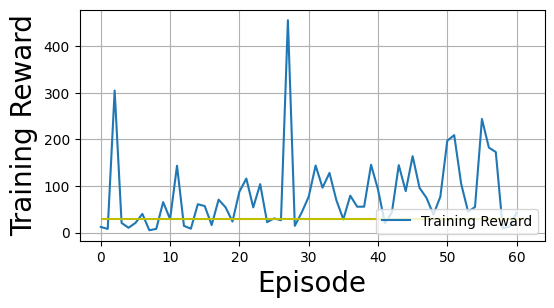

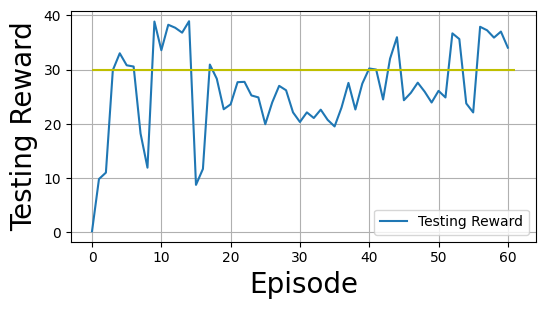

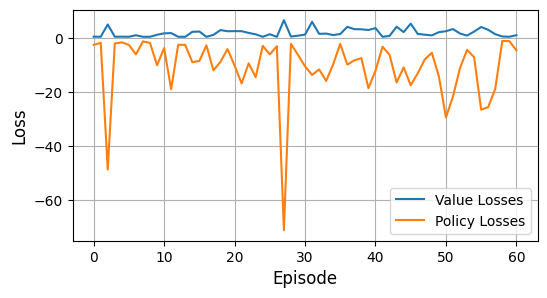

30.079680000000003

In [25]:
env_train, env_test = initialize_env(best_model_cpu)
run_agent(env_train=env_train,
          env_test=env_test,
          discount_factor=0.90,
          epsilon=0.31,
          entropy_coefficient=0.08,
          hidden_dimensions=64,
          dropout=0.22,
          batch_size=32,
          learning_rate=0.0003,
          max_grad_norm=10.0,
          algorithm="PPO")

#### Results with the A2C agent:

Initialized 2 VMs.


C:\Users\killi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\envs\registration.py:623: UserWarning: WARN: The environment is being initialised with mode (rgb_array) that is not in the possible render_modes ([]).
  logger.warn(


Episode 10: Mean Train Rewards: 35.31, Mean Test Rewards: 16.67, Mean Policy Loss: 5.5136, Mean Value Loss: 1.3292, Avg Entropy: 1.3745
Episode 20: Mean Train Rewards: 44.46, Mean Test Rewards: 19.63, Mean Policy Loss: 7.0566, Mean Value Loss: 1.2767, Avg Entropy: 1.3605
Episode 30: Mean Train Rewards: 53.55, Mean Test Rewards: 23.05, Mean Policy Loss: 9.5003, Mean Value Loss: 1.4439, Avg Entropy: 1.2958
Episode 40: Mean Train Rewards: 60.26, Mean Test Rewards: 24.79, Mean Policy Loss: 11.4364, Mean Value Loss: 1.5684, Avg Entropy: 1.2508
Episode 50: Mean Train Rewards: 93.56, Mean Test Rewards: 26.45, Mean Policy Loss: 16.8580, Mean Value Loss: 2.0141, Avg Entropy: 1.3032
Episode 60: Mean Train Rewards: 106.42, Mean Test Rewards: 27.46, Mean Policy Loss: 17.9678, Mean Value Loss: 2.3644, Avg Entropy: 1.2863
Early stopping at episode 68 due to reward threshold.


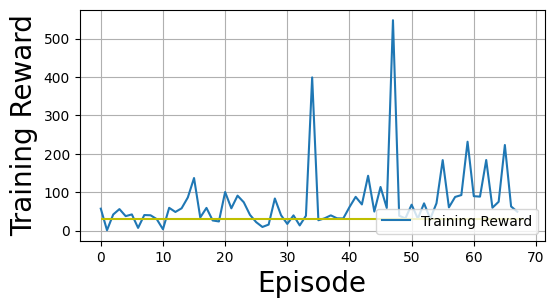

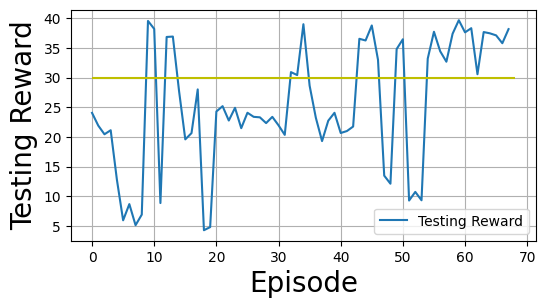

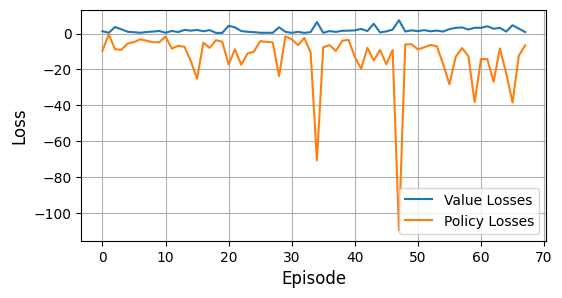

31.02108

In [26]:
env_train, env_test = initialize_env(best_model_cpu)
run_agent(env_train=env_train,
          env_test=env_test,
          discount_factor=0.90,
          epsilon=0.0,
          entropy_coefficient=0.08,
          hidden_dimensions=64,
          dropout=0.22,
          batch_size=32,
          learning_rate=0.0003,
          max_grad_norm=10.0,
          algorithm="A2C")

#### Hyperparameter Optimization

In [ ]:
class Optimizer:
    def __init__(self, agent, model):
        self.agent = agent
        self.model = model

    def objective(self, trial):
        params = {
            "discount_factor": trial.suggest_float('discount_factor', 0.8, 1.0),
            "learning_rate": trial.suggest_loguniform('learning_rate', 1e-4, 1e-3),
            "batch_size": trial.suggest_categorical('batch_size', [32, 64, 128]),
            "epsilon": trial.suggest_float('epsilon', 0.2, 0.4),
            "entropy_coefficient": trial.suggest_float('entropy_coefficient', 0.01, 0.1),
            "hidden_dimensions": trial.suggest_categorical('hidden_dimensions', [32, 64, 128]),
            "dropout": trial.suggest_float('dropout', 0.2, 0.5),
            "max_grad_norm": trial.suggest_categorical('max_grad_norm', [1.0, 5.0, 10.0, 50.0])
            }
    
        env_train, env_test = initialize_env(self.model)
        
        n_test_rewards = run_agent(
            env_train=env_train,
            env_test=env_test,
            discount_factor=params["discount_factor"],
            epsilon=params["epsilon"],
            entropy_coefficient=params["entropy_coefficient"],
            hidden_dimensions=params["hidden_dimensions"],
            dropout=params["dropout"],
            batch_size=params["batch_size"],
            learning_rate=params["learning_rate"],
            max_grad_norm=params["max_grad_norm"],
            algorithm=self.agent
            )
    
        return n_test_rewards

    def optimize_hyperparameters(self):
        study = optuna.create_study(direction='maximize')
        
        study.optimize(self.objective, n_trials=10)
        
        print("Best hyperparameters: ", study.best_params)
        print("Best test reward: ", study.best_value)

# Run the optimization
optimizer = Optimizer(agent="PPO", model=best_model_cpu)
optimizer.optimize_hyperparameters()